In [18]:
import os, pandas as pd, requests

DATA_RAW = "../data/raw"
DATA_INTERIM = "../data/interim"
os.makedirs(DATA_RAW, exist_ok=True)
os.makedirs(DATA_INTERIM, exist_ok=True)

In [19]:
from io import StringIO

# Paths
DATA_RAW = "../data/raw"
os.makedirs(DATA_RAW, exist_ok=True)

# API endpoint
base_url = "https://ffiec.cfpb.gov/v2/data-browser-api/view/csv"

params = {
    "years": "2022",
    "states": "CA",
    "loanTypes": "1",      # conventional
    "propertyTypes": "1",  # 1–4 family, site-built
    "occupancyTypes": "1", # primary
    "lienStatuses": "1",    # first lien
    "loan_purposes": "1"    # purchase loans
}

# Add User-Agent header to avoid 403
headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
}

resp = requests.get(base_url, params=params, headers=headers)
resp.raise_for_status()

# Read CSV from response 
df_raw = pd.read_csv(StringIO(resp.text))

# Save raw pull
raw_out = os.path.join(DATA_RAW, "hmda_ca2022_raw.csv")
df_raw.to_csv(raw_out, index=False)

print("Rows, Cols:", df_raw.shape)
df_raw.head(3)

/var/folders/ty/9hbmbw6113l8wpm40mbk4qk40000gn/T/ipykernel_91802/2934110892.py:30: DtypeWarning: Columns (22,23,24,26,27,28,29,30,31,32,33,38,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(StringIO(resp.text))


Rows, Cols: (611698, 99)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,...,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units
0,2022,549300FGXN1K3HLB1R50,40900,CA,6061.0,6.061024e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4361,11.10,102400,97.88,2252,2634,0
1,2022,549300FGXN1K3HLB1R50,40900,CA,6067.0,6.067009e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,8897,54.51,102400,173.83,2287,2568,21
2,2022,549300FGXN1K3HLB1R50,31084,CA,6037.0,6.037481e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,...,NaN,NaN,NaN,4183,57.54,91100,186.97,696,1045,65


In [20]:
DATA_INTERIM = "../data/interim"
os.makedirs(DATA_INTERIM, exist_ok=True)

# From previous cell
cohort = df_raw.copy()

# Ensure numeric types
cohort["loan_to_value_ratio"] = pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce")
cohort["income"] = pd.to_numeric(cohort["income"], errors="coerce")
cohort["loan_amount"] = pd.to_numeric(cohort["loan_amount"], errors="coerce")
cohort["rate_spread"] = pd.to_numeric(cohort["rate_spread"], errors="coerce")

# Convert race and ethnicity indicators to numbers
int_fields = [
    "applicant_race-1", "co-applicant_race-1",
    "applicant_ethnicity-1", "co-applicant_ethnicity-1",
    "applicant_race_observed"
]
for col in int_fields:
    cohort[col] = pd.to_numeric(cohort[col], errors="coerce").astype("Int64")

# Define race indicator
def classify_race(row):
    app_race = row["applicant_race-1"]
    co_app_race = row["co-applicant_race-1"]
    app_eth = row["applicant_ethnicity-1"]
    co_app_eth = row["co-applicant_ethnicity-1"]
    app_obs = row["applicant_race_observed"]

    # In cases where the co-applicant is identified as ‘White’ and the applicant is of a different race, we reclassify the applicant’s race as ‘White’ 
    if (pd.notna(app_race) and app_race == 5) or (pd.notna(co_app_race) and co_app_race == 5):
        return "White"

    # Hispanic as a distinct group regardless of race
    if (pd.notna(app_eth) and app_eth in [1, 11, 12, 13, 14]) or \
       (pd.notna(co_app_eth) and co_app_eth in [1, 11, 12, 13, 14]):
        return "Hispanic or Latino"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_race):
        if app_race == 1:
            return "American Indian or Alaska Native"
        if app_race in [2] + list(range(21, 28)):
            return "Asian"
        if app_race == 3:
            return "Black or African American"
        if app_race in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    # Classify race group based on the primary applicant's race
    if pd.notna(app_obs):
        if app_obs == 1:
            return "American Indian or Alaska Native"
        if app_obs in [2] + list(range(21, 28)):
            return "Asian"
        if app_obs == 3:
            return "Black or African American"
        if app_obs in [4, 41, 42, 43, 44]:
            return "Pacific Islander"

    return "Other / Unknown"

# Apply race classification
cohort["race_group"] = cohort.apply(classify_race, axis=1)

# Drop loans with missing/undisclosed race
cohort = cohort[cohort["race_group"] != "Other / Unknown"].copy()

# Add relative income to area median to control for local affordability
cohort["income_ratio"] = cohort["income"] * 1000 / cohort["ffiec_msa_md_median_family_income"]

# Bucket income into three classification CRA & Apgar (2007)
def income_bucket(ratio):
    if pd.isna(ratio):
        return "Unknown"
    elif ratio < 0.8:
        return "Low (<80%)"
    elif ratio <= 1.2:
        return "Moderate (80–120%)"
    else:
        return "High (>120%)"

cohort["income_bucket"] = cohort["income_ratio"].apply(income_bucket)

# Exclude intro-rate loans
cohort = cohort[cohort["intro_rate_period"].isna()].copy()

# Exclude extreme LTV values (potential data entry error)
cohort = cohort[pd.to_numeric(cohort["loan_to_value_ratio"], errors="coerce") < 120].copy()

# Drop loans with income <= 0
cohort = cohort[cohort["income"] > 0].copy()

# Drop NAs for key predictors
cohort = cohort[
    cohort["rate_spread"].notna()
    & cohort["loan_to_value_ratio"].notna()
    & cohort["income"].notna()
    & (cohort["income"] > 0)
    & cohort["debt_to_income_ratio"].notna()
    & (cohort["debt_to_income_ratio"] != "")
].copy()

# Drop extreme rate spread cases > 15 (likely data errors)
cohort = cohort[cohort["rate_spread"] <= 15].copy()

# Clean DTI (numeric)
def clean_dti(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    mapping = {
        "<20%": 15,
        "20%-<30%": 25,
        "30%-<36%": 33,
        "50%-60%": 55,
        ">60%": 65,
        "NA": None,
        "Exempt": None
    }
    if val in mapping:
        return mapping[val]
    try:
        return float(val.strip("%"))
    except:
        return None

cohort["dti_clean"] = cohort["debt_to_income_ratio"].apply(clean_dti)

# Add categorical buckets for DTI 
def bucket_dti(val):
    if pd.isna(val):
        return "Unknown"
    val = str(val).strip()
    mapping = {
        "<20%": "<20%",
        "20%-<30%": "20–30%",
        "30%-<36%": "30–36%",
        "50%-60%": "50–60%",
        ">60%": ">60%",
        "NA": "Unknown",
        "Exempt": "Unknown"
    }
    if val in mapping:
        return mapping[val]
    try:
        pct = float(val.strip("%"))
        if pct < 20:
            return "<20%"
        elif pct < 30:
            return "20–30%"
        elif pct < 36:
            return "30–36%"
        elif pct <= 50:
            return "36–50%"
        elif pct <= 60:
            return "50–60%"
        else:
            return ">60%"
    except:
        return "Unknown"

cohort["dti_bucket"] = cohort["debt_to_income_ratio"].apply(bucket_dti)

# Reset index
cohort.reset_index(drop=True, inplace=True)

# Save interim dataset 
out_path = os.path.join(DATA_INTERIM, "hmda_ca2022_conventional.csv")
cohort.to_csv(out_path, index=False)

# Print summary 
print(f"Cohort saved: {out_path}")
print("Rows:", len(cohort))
print("\nRace group counts:")
print(cohort["race_group"].value_counts())

Cohort saved: ../data/interim/hmda_ca2022_conventional.csv
Rows: 260776

Race group counts:
race_group
White                               149845
Asian                                83205
Hispanic or Latino                   13992
Black or African American            12267
American Indian or Alaska Native       787
Pacific Islander                       680
Name: count, dtype: int64


In [21]:
# Flag extreme rate spreads (plot showing extreme tail, potential data error)
cohort["rate_spread_flag"] = cohort["rate_spread"] > 15
print("Extreme cases flagged:", cohort["rate_spread_flag"].sum())

Extreme cases flagged: 0


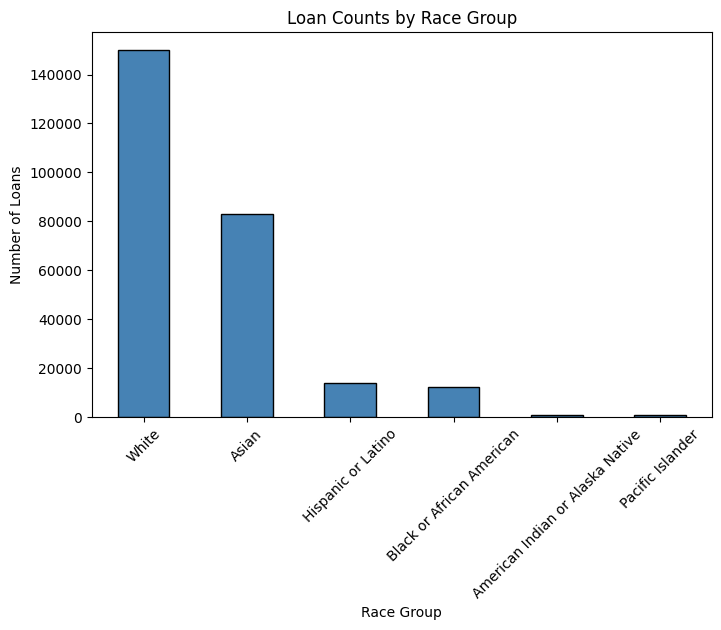

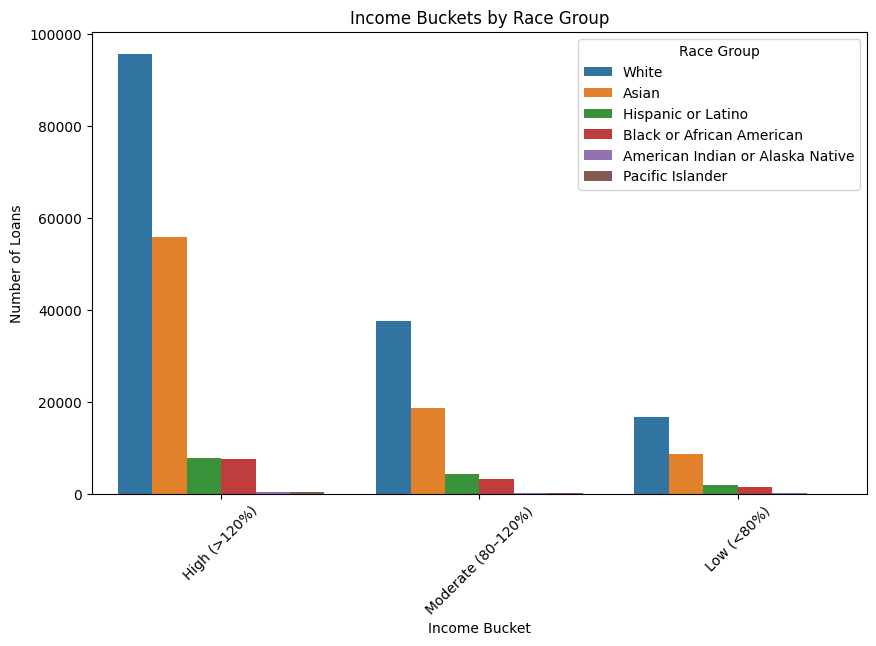

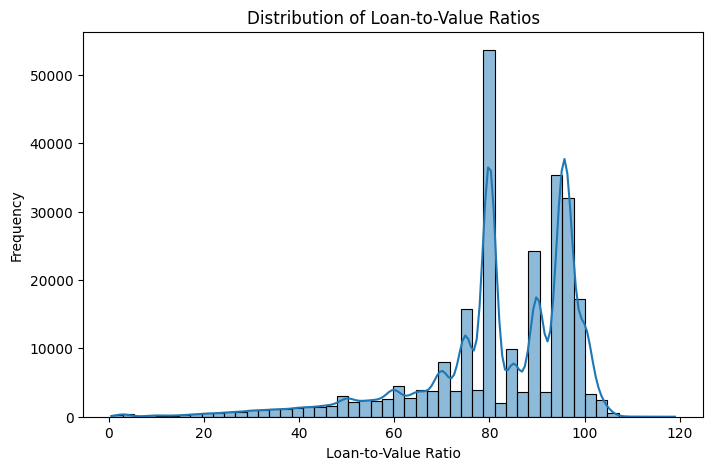

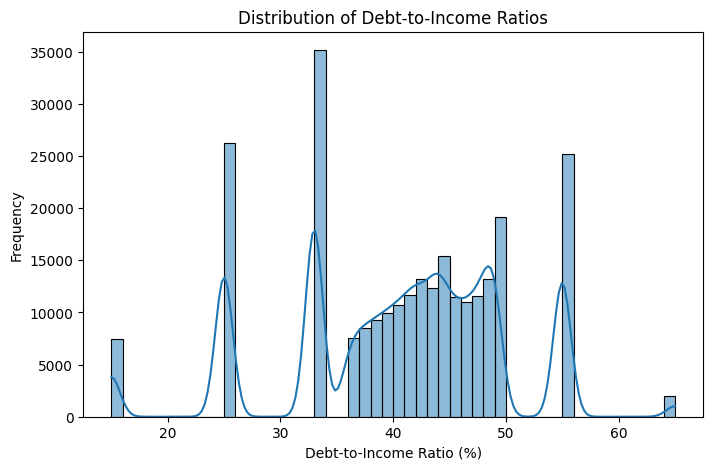

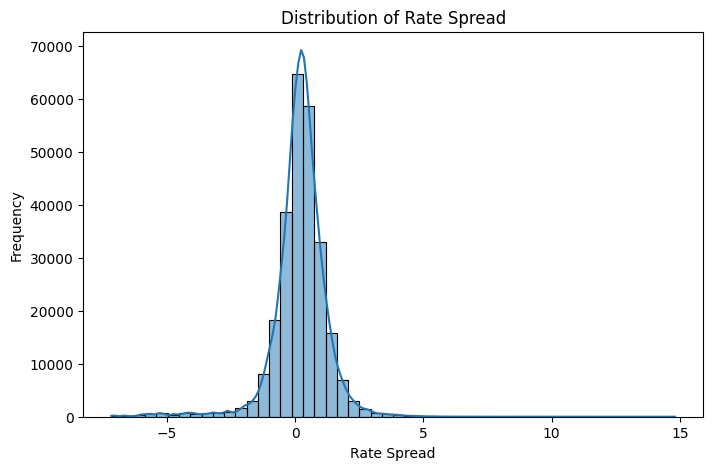

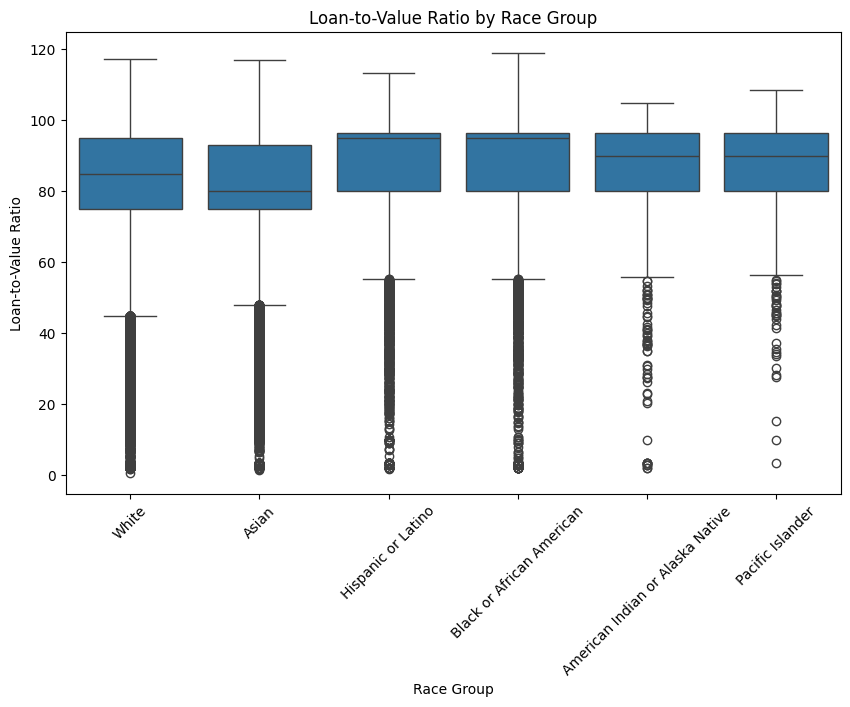

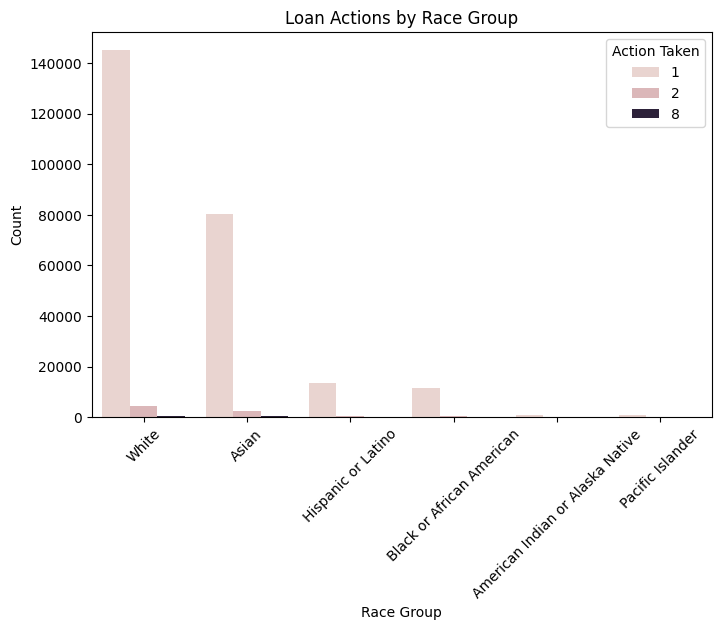

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Race Group Distribution
plt.figure(figsize=(8,5))
cohort["race_group"].value_counts().plot(kind="bar", color="steelblue", edgecolor="black")
plt.title("Loan Counts by Race Group")
plt.ylabel("Number of Loans")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.show()

# 2. Income Buckets by Race
plt.figure(figsize=(10,6))
sns.countplot(data=cohort, x="income_bucket", hue="race_group")
plt.title("Income Buckets by Race Group")
plt.ylabel("Number of Loans")
plt.xlabel("Income Bucket")
plt.xticks(rotation=45)
plt.legend(title="Race Group")
plt.show()

# 3. Loan-to-Value Ratio Distribution
plt.figure(figsize=(8,5))
sns.histplot(cohort["loan_to_value_ratio"], bins=50, kde=True)
plt.title("Distribution of Loan-to-Value Ratios")
plt.xlabel("Loan-to-Value Ratio")
plt.ylabel("Frequency")
plt.show()

# 4. Debt-to-Income Ratio Distribution
plt.figure(figsize=(8,5))
sns.histplot(cohort["dti_clean"], bins=50, kde=True)
plt.title("Distribution of Debt-to-Income Ratios")
plt.xlabel("Debt-to-Income Ratio (%)")
plt.ylabel("Frequency")
plt.show()

# 5. Rate Spread Distribution (can signal skew)
plt.figure(figsize=(8,5))
sns.histplot(cohort["rate_spread"], bins=50, kde=True)
plt.title("Distribution of Rate Spread")
plt.xlabel("Rate Spread")
plt.ylabel("Frequency")
plt.show()

# 6. Boxplot of LTV by Race Group
plt.figure(figsize=(10,6))
sns.boxplot(data=cohort, x="race_group", y="loan_to_value_ratio")
plt.title("Loan-to-Value Ratio by Race Group")
plt.ylabel("Loan-to-Value Ratio")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.show()

# 7. Approval proxy (action_taken) by race group
plt.figure(figsize=(8,5))
sns.countplot(data=cohort, x="race_group", hue="action_taken")
plt.title("Loan Actions by Race Group")
plt.ylabel("Count")
plt.xlabel("Race Group")
plt.xticks(rotation=45)
plt.legend(title="Action Taken")
plt.show()

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

DATA_PROCESSED = "../data/processed"
os.makedirs(DATA_PROCESSED, exist_ok=True)

# From interim file
df = cohort.copy()

# Raw income is highly sckewed. Log-transormation to compress high income to prep for logistic regression
df["log_income"] = np.log1p(df["income"])

# Add Metro area dummies to control for location-level effects
df["msa_md"] = df["derived_msa-md"].astype("category")
df = pd.get_dummies(df, columns=["msa_md"], prefix="msa", drop_first=True)

# Add Purchaser type dummies to control for channels
df["purchaser_type"] = df["purchaser_type"].astype("category")
df = pd.get_dummies(df, columns=["purchaser_type"], prefix="purch", drop_first=True)

# Keep LEI as categorical for control for lender fixed effects
df["lei"] = df["lei"].astype("category")

# Define outcome (1=approved, 0=denied)
df["approved"] = (df["action_taken"] == 1).astype(int)

# Convert categorical columsn into dummy variables
    #	White = baseline race
    #	<20% = baseline DTI bucket
    #	Low income (<80%) = baseline income bucket
df = pd.get_dummies(df, columns=["race_group", "dti_bucket", "income_bucket"], drop_first=True)

# Train/Test split stratified by approval outcome
train, test = train_test_split(df, test_size=0.3, stratify=df["approved"], random_state=42)

# Save full, train, and test datasets
out_full = os.path.join(DATA_PROCESSED, "hmda_ca2022_model_ready.csv")
out_train = os.path.join(DATA_PROCESSED, "hmda_ca2022_train.csv")
out_test = os.path.join(DATA_PROCESSED, "hmda_ca2022_test.csv")

df.to_csv(out_full, index=False)
train.to_csv(out_train, index=False)
test.to_csv(out_test, index=False)

# Print summary
print(f"Processed dataset saved:")
print(f"  Full:  {out_full} ({len(df)} rows)")
print(f"  Train: {out_train} ({len(train)} rows)")
print(f"  Test:  {out_test} ({len(test)} rows)")

print("\nApproval rate check (train vs test):")
print("Train:", train['approved'].mean())
print("Test :", test['approved'].mean())


Processed dataset saved:
  Full:  ../data/processed/hmda_ca2022_model_ready.csv (260776 rows)
  Train: ../data/processed/hmda_ca2022_train.csv (182543 rows)
  Test:  ../data/processed/hmda_ca2022_test.csv (78233 rows)

Approval rate check (train vs test):
Train: 0.9669666873010743
Test : 0.9669576777063388


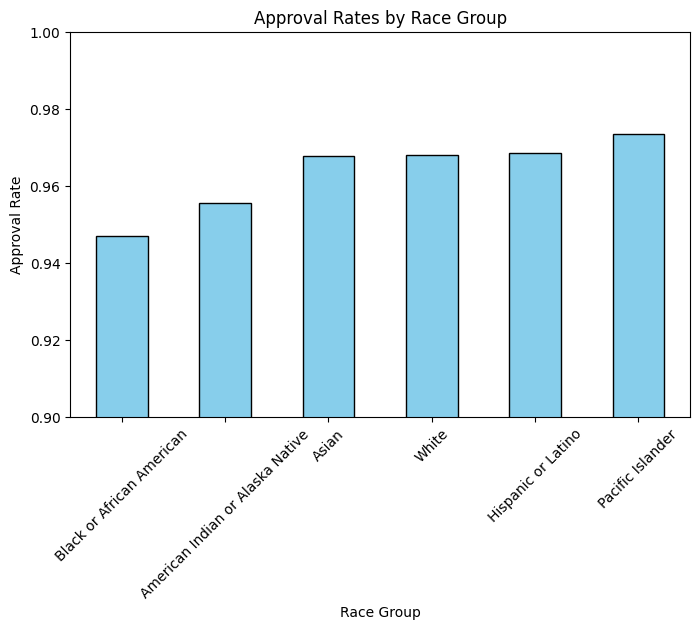

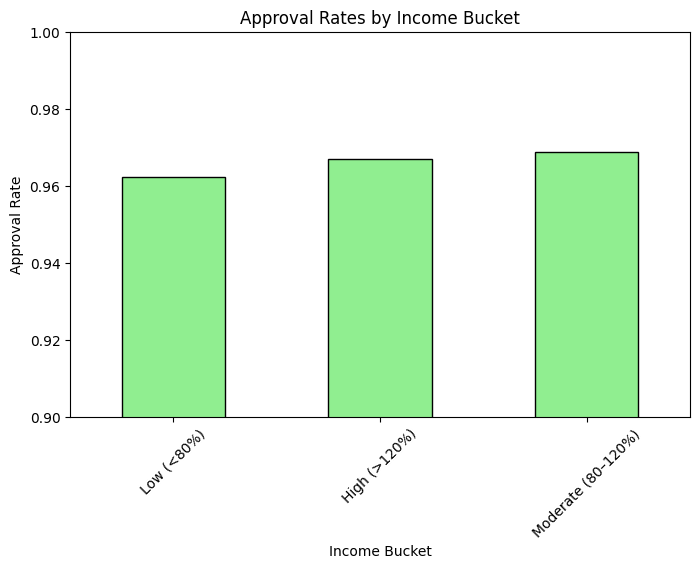

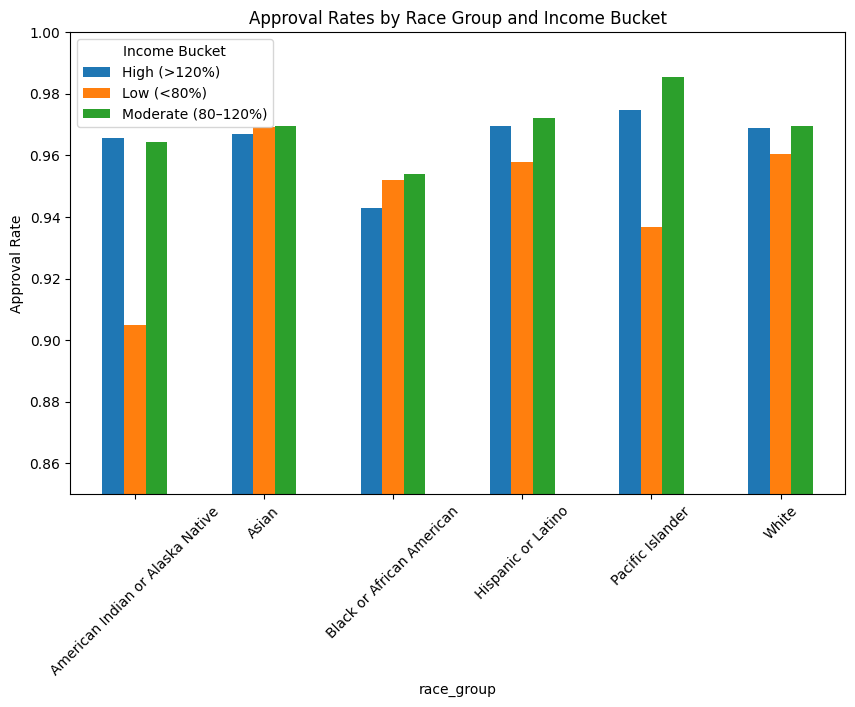

In [24]:
# --- Approval rates by race group ---
approval_by_race = cohort.groupby("race_group")["action_taken"].apply(lambda x: (x==1).mean()).sort_values()

plt.figure(figsize=(8,5))
approval_by_race.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Approval Rates by Race Group")
plt.ylabel("Approval Rate")
plt.xlabel("Race Group")
plt.ylim(0.9, 1.0)  # zoom in since approval rates are very high
plt.xticks(rotation=45)
plt.show()

# --- Approval rates by income bucket ---
approval_by_income = cohort.groupby("income_bucket")["action_taken"].apply(lambda x: (x==1).mean()).sort_values()

plt.figure(figsize=(8,5))
approval_by_income.plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Approval Rates by Income Bucket")
plt.ylabel("Approval Rate")
plt.xlabel("Income Bucket")
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)
plt.show()

# --- Combined: Race x Income Bucket ---
approval_race_income = cohort.groupby(["race_group", "income_bucket"])["action_taken"].apply(lambda x: (x==1).mean()).unstack()

approval_race_income.plot(kind="bar", figsize=(10,6))
plt.title("Approval Rates by Race Group and Income Bucket")
plt.ylabel("Approval Rate")
plt.ylim(0.85, 1.0)
plt.legend(title="Income Bucket")
plt.xticks(rotation=45)
plt.show()